In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import minihack
from minihack import RewardManager
from minihack import LevelGenerator
from nle import nethack
from utils import *
import IPython.display as display
import time
import numpy as np
from typing import List, Tuple, Set
from algorithms import *
from algorithms_2 import *
from MCTS import *

In [2]:
def stairs_reward_function(env, previous_observation, action, observation):
    # Agent is on stairs down
    if observation[env._internal_index][4]:
        return 1
    return 0

In [3]:
# Define a 10x10 room and populate it with
# different objects, monster and features

map3_str = """
-----------------
|..L....L....L..|
|..L..LLL..L.LL.|
|..L..L.....L.L.|
|.....L.....L...|
|..L....L....L..|
|..LLL..L.LLLL..|
|..L.L..L..L....|
|..L....L....L..|
|.....L.....L...|
-----------------
"""


lava_maze = (
    "----------------------\n"
    "|..L.......L......L...|\n"
    "|..L..LLL..L.LLL..L...|\n"
    "|..L..L....L...L..L...|\n"
    "|.....L........L......|\n"
    "----------------------"
)

simple_room = """
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............

"""
lvl_gen = LevelGenerator(map=map3_str)

# Generate random positions for apples
apple_count = 4

for pos in range(0,apple_count):
    lvl_gen.add_object("apple", "%")

lvl_gen.add_stair_down(place=None)

# lvl_gen.set_start_pos((0, 0))
# lvl_gen.add_object("apple", "%", place=(5, 7))
# lvl_gen.add_object("apple", "%", place=(3, 6))
# lvl_gen.add_object("apple", "%", place=(5, 2))
# lvl_gen.add_object("apple", "%", place=(7, 9))
# lvl_gen.add_stair_down(place=(7, 7))

MOVE_ACTIONS = tuple(nethack.CompassDirection)
ACTIONS = MOVE_ACTIONS + (nethack.Command.EAT, nethack.Command.PICKUP, nethack.Command.INVENTORY) + tuple(
    range(ord('a'), ord('z') + 1))

# Define a reward manager
reward_manager = RewardManager()
# +1 reward and termination for eating
# an apple
reward_manager.add_eat_event("apple", reward=0.75, repeatable=True, terminal_required=False, terminal_sufficient=False)
# Will never be achieved, but insures the environment keeps running
reward_manager.add_message_event(
    ["Mission Complete."],
    terminal_required=True,
    terminal_sufficient=True,
)
reward_manager.add_custom_reward_fn(stairs_reward_function)
env = gym.make(
    "MiniHack-Skill-Custom-v0",
    des_file=lvl_gen.get_des(),
    reward_manager=reward_manager,
    observation_keys=("glyphs", "chars", "colors", 'screen_descriptions', 'inv_strs', 'blstats', 'message', 'pixel'),
    actions=ACTIONS,
    penalty_time = -0.1
)
obs, info = env.reset()  # each reset generates a new environment instance
env.render()


Hello Agent, welcome to NetHack!  You are a neutral human Caveman.              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                              -----------------                                 
                              |..}....}....}..|                                 
                              |%.}..}}}..}.}}.|                                 
                              |..}..}.....}.}.|                                 
                              |.....}...@.}...|                                 
                              |.%}>...}....}..|                                 
                           

Apple positions: [(np.int64(9), np.int64(34)), (np.int64(13), np.int64(35)), (np.int64(14), np.int64(32)), (np.int64(14), np.int64(33))]


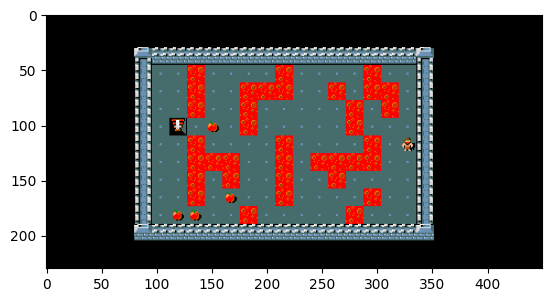

In [11]:

state, _ = env.reset()
game_map = state['chars']
game = state['pixel']
start = get_player_location(game_map)
target = get_target_location(game_map)

char_map = np.vectorize(chr)(game_map)
apple_positions = np.where(char_map == '%')
# zip into a list of int tuples (x, y)
apple_positions = list(zip(apple_positions[0], apple_positions[1]))
print("Apple positions:", apple_positions)
plt.imshow(state['pixel'][50:280, 400:850])
# plt.imshow(state['pixel'][100:280, 535:710])

In [17]:
path = mcts(game_map, start, target, set(apple_positions), iterations=10000)

# Optional: Convert numpy types (if needed)
path = [(int(x), int(y)) for x, y in path]

print("MCTS path:", path)
actions = actions_from_path(start, path[1:])
simulate_path(path, game_map, actions)

MCTS path: [(10, 45), (11, 45), (12, 45), (12, 44), (12, 43), (12, 42), (13, 42), (13, 41), (13, 40), (14, 40), (14, 39), (14, 38), (14, 37), (13, 37), (13, 36), (13, 35), (13, 34), (14, 34), (14, 33), (14, 32), (13, 32), (12, 32), (11, 32), (10, 32), (9, 32)]
Actions to take: ['DOWN', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'UP', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'UP', 'UP', 'UP', 'UP', 'UP']
Apple collected in the path: 3
Expected Reward:  0.75
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                              -----------------                                
       

In [13]:
path = a_star_collect_apples(game_map, start, target, set(apple_positions),  weight=1)
path = [state[0] for state in path]
path = [(int(x), int(y)) for (x, y) in path]
actions = actions_from_path(start, path[1:])
simulate_path(path, game_map, actions)

Actions to take: ['LEFT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'UP', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'RIGHT', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'UP', 'UP', 'UP', 'LEFT', 'UP', 'LEFT', 'LEFT', 'LEFT']
Apple collected in the path: 4
Expected Reward:  0.6999999999999997
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                              -----------------                                
                              |..}....}....}..|                                
                              |..}..}}}..}.}}.|                                
                          

In [14]:
path = a_star_apple(game_map, start, target, manhattan_distance, apple_bonus=3)
actions = actions_from_path(start, path[1:])
simulate_path(path, game_map, actions)

Actions to take: ['LEFT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'UP', 'LEFT', 'UP', 'UP', 'UP', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'UP', 'LEFT', 'LEFT', 'LEFT']
Apple collected in the path: 1
Expected Reward:  -0.5500000000000003
                                                                               
                                                                               
                                                                               
                                                                               
                                                                               
                              -----------------                                
                              |..}....}....}..|                                
                              |..}..}}}..}.}}.|                                
                              |..}..}.....}.}.|                                
                           

In [15]:
score, path = beam_search_path_planner(game_map, start, target, apple_positions, beam_width=5, apple_reward=7.5)
actions = actions_from_path(start, path[1:])
simulate_path(path, game_map, actions)

Exception: x and y can't change at the same time. oblique moves not allowed!

In [18]:
PICKUP = env.unwrapped.actions.index(nethack.Command.PICKUP)
EAT = env.unwrapped.actions.index(nethack.Command.EAT)
INVENTORY = env.unwrapped.actions.index(nethack.Command.INVENTORY)


def check_and_eat_apple(state, env):
    """
    Check if the player is on an apple and eat it.
    """
    game_map = state['chars']
    player_location = get_player_location(game_map)
    if player_location in apple_positions:
        # Pick up the apple
        print("Found apple at:", player_location)
        s, _, done, _, dic = env.step(PICKUP)
        print("ACTION_TAKEN: PICKUP")
        apple_positions.remove(player_location)  # Remove the apple from the list
        s, _, done, _, dic = env.step(EAT)
        # What do you want to eat?[g or *]
        msg = bytes(s['message']).decode('utf-8').rstrip('\x00')
        print(msg)
        food_char = msg.split('[')[1][0]  # Because of the way the message in NetHack works

        # print("Food character to eat:", food_char)
        # Eat the apple
        # Open inventory to find the apple letter
        s, reward, done, boh, dic = env.step(env.unwrapped.actions.index(ord(food_char)))
        print("ACTION_TAKEN: EAT", food_char)
        msg = bytes(s['message']).decode('utf-8').rstrip('\x00')
        print(msg)
        return s, reward, done, boh, dic

    # If not on an apple, just return the state
    return state, 0, False, None, None


Action taken: UP
Episode finished: {'end_status': <StepStatus.TASK_SUCCESSFUL: 2>, 'is_ascended': False}
Reward: 0.5499999999999997


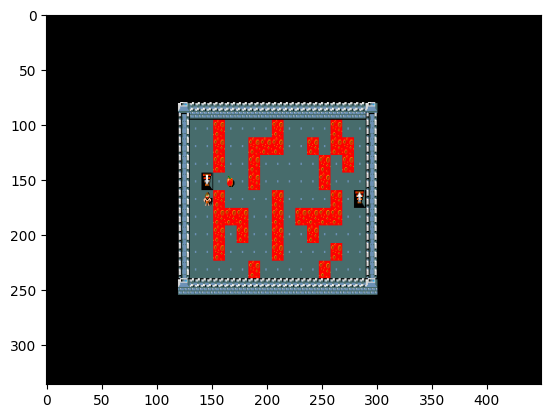

In [19]:
# env.reset()
image = plt.imshow(game[:, 400:850])
tot_reward = 0
for action in actions:
    s, reward, done, _, dic = env.step(action)
    tot_reward += reward
    if not done:
        # check and eat apple
        s, reward, _, _, _ = check_and_eat_apple(s, env)
        tot_reward += reward
        display.display(plt.gcf())
        print("Reward:", tot_reward)
        display.clear_output(wait=True)
        time.sleep(0.5)
        image.set_data(s['pixel'][:, 300:975])
        print("Action taken:", directions[action])
    else:
        print(f"Episode finished:", dic)
        print("Reward:", tot_reward)
        break
